In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector
from dataset import SKDS, TVDS

from torch.optim import Adam
from torch.nn import MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision.models

<class 'dataset.SKDS'> dataset created...
epoch: 0 of 10, train loss: 10940.169874621975, val loss: 1225.0346272786458, lr: 0.01
epoch: 1 of 10, train loss: 1221.9806262600807, val loss: 1411.9472249348958, lr: 0.01
epoch: 2 of 10, train loss: 1100.7872786983366, val loss: 875.6812133789062, lr: 0.01
epoch: 3 of 10, train loss: 904.5651579826109, val loss: 1282.8047688802083, lr: 0.01
epoch: 4 of 10, train loss: 882.4562456684728, val loss: 1046.3340454101562, lr: 0.01
epoch: 5 of 10, train loss: 828.4625815114667, val loss: 770.1886800130209, lr: 0.01
epoch: 6 of 10, train loss: 877.7155702652469, val loss: 1014.0968627929688, lr: 0.01
epoch: 7 of 10, train loss: 769.4588770712576, val loss: 780.9700113932291, lr: 0.01
epoch: 8 of 10, train loss: 897.7370310137348, val loss: 592.5671183268229, lr: 0.01
epoch: 9 of 10, train loss: 965.8384182837701, val loss: 919.6786295572916, lr: 0.01
test loss: 1204.1315104166667
y_pred:
tensor([[ 230.2299],
        [ 193.1046],
        [-285.8599],

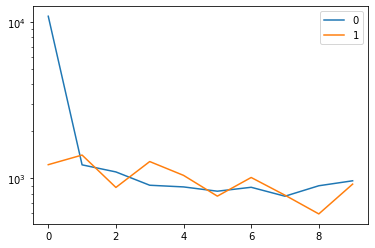

learning time: 0:00:07.710880


In [2]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'make': 'make_regression',
             'sk_params': {'n_samples': 10000,
                           'n_features': 128}}

opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 2}

l = Learn(SKDS, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=10)

In [ ]:
model_params = {'model_name': 'resnet18',
                'D_in': 28,
                'D_out': 10,
                'tv_params': {}}

ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': True,
                         'target_transform': None}}
           
opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 10}

l = Learn(TVDS, tv_model, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=16, epochs=10)

In [ ]:
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': True,
                         'target_transform': None}}

tvds = TVDS(**ds_params)

In [ ]:
tvds[1]

In [ ]:
tvds[2][0].shape

In [ ]:
model_params = {'model_name': 'resnet18',
                'D_in': 224,
                'D_out': 10,
                'tv_params': {}}

tvmodel = tv_model(**model_params)

In [ ]:
dir(tvmodel)

In [ ]:
type(tvmodel)

In [ ]:
isinstance(tvmodel, torchvision.models.resnet.ResNet)

In [ ]:
list(tvmodel.named_modules())

In [ ]:
a = {'b': 1, 'c': 2, 'd': {'e': 10, 'f': 20}}

def myfunc(b=None, d=None, **kwargs):
    print('b: ', b)
    
    def f(e=None, **kwargs):
        print('e :', e)
    
    f(**d)
    
myfunc(**a)
    

In [ ]:
def A():
    b = [1,2,3,4,5]
    c = [4,5,6]

    for i in range(len(b)):
        try: yield b[i], c[i]
        except: yield b[i]

In [ ]:
a = A()

In [ ]:
out = next(a)

In [ ]:
print(out)